Importing required packages

In [67]:
from parsebrologs import ParseBroLogs # To import conn logs 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import json

## Regular Traffic Data

In [2]:
## Reading the conn logs for our analysis
os.listdir(os.getcwd() + "/2018-05-26/")[0]

'conn.00_00_00-01_00_00.log'

In [3]:
log_data = ParseBroLogs("2018-05-26/conn.00_00_00-01_00_00.log")
regular_traffic = pd.DataFrame(json.loads(log_data.to_json()))

In [4]:
#regular_traffic['Time_stamp'] = regular_traffic['ts'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(pd.to_numeric(x))))

In [5]:
regular_traffic.head()

,conn_state,duration,history,id.orig_h,id.orig_p,id.resp_h,id.resp_p,local_orig,local_resp,missed_bytes,orig_bytes,orig_ip_bytes,orig_pkts,proto,resp_bytes,resp_ip_bytes,resp_pkts,service,ts,uid
0,S0,-,S,46.182.25.42,60000,128.143.67.25,8000,F,F,0,-,-,-,tcp,-,-,-,-,1527307194.170627,CI1zj1iwKyHwKBBx9
1,RSTO,5.802564,ShADadfR,128.143.71.88,38652,52.3.226.246,80,F,F,0,696,-,-,tcp,1837,-,-,http,1527307188.411720,CqGWoa28t2nYR9UzJa
2,S0,-,S,186.212.105.114,11204,128.143.137.226,23,F,F,0,-,-,-,tcp,-,-,-,-,1527307194.316096,C6RNAOaJg17ubLtH6
3,S0,-,D,184.105.139.97,60205,199.111.218.190,177,F,F,0,-,-,-,udp,-,-,-,-,1527307139.337981,CUgKV91onic5lFmCm5
4,SF,119.972539,ShADadFfR,128.143.67.174,53649,23.13.154.167,443,F,F,0,914,-,-,tcp,3337,-,-,ssl,1527307074.521843,CJJmEo2zIyALhBvzNe


## Fireeye data

In [68]:
os.listdir(os.getcwd() + "/fireeye")[1]

'felog-2018-03-16.log'

#### Function to clean the strings from the input data

In [69]:
def replace_string(string, list_of_strings):
    
    for each in range(len(list_of_strings)):
        current_element = list_of_strings[each]
        
        # Assigning the changes to be made to each string type
        starting_str = current_element[0]
        ending_str = current_element[1]
        str_to_replace = current_element[2]
        new_str = current_element[3]
        
        st = string.find(starting_str)
        end = string[st:].find(ending_str)
        
        string = string[0:st] + string[st:(st+end)].replace(str_to_replace,new_str) + string[(st+end):]
        
    return string

### Reading fireeye files - Fireeye Parser
1) Handle the strings - not all are separated by | operator

2) First 4 columns are separated by | while the last column is separted by space (not all! Especially columns like rt which has rate in it)

In [70]:
file_to_read = "fireeye/felog-2018-05-26.log"

In [72]:
file_lines = []
col_names_col1 = ['TimeStamp',"Server","Warning","CEF"]
col_names = ['Fireeye','CMS_value','ID_no','MC_type','malware','callback_number']

with open(file_to_read) as file:
    counter = 0
    for line in file:
        counter += 1
        
        list_of_dicts = []
        split_lines = line.split("|")
        split_lines_1 = split_lines[0:7]
        split_lines_2 = " ".join(split_lines[7:])
        split_lines_1.append(split_lines_2)
        split_lines = split_lines_1
        last_element = replace_string(split_lines[-1],[("rt=","UTC "," ","_"),("~~Date:"," GMT::"," ","_")])
        #print(last_element)
        
        #print(last_element)
        last_element = last_element.split(" ")
        first_element = split_lines[0]
        current_list = split_lines[1:-1]
        
        ### Assigning the column names to the current list
        
        first_element = [col_names_col1[pos]+ "="+value for pos, value in enumerate(first_element.split(" "))]
        current_list = [col_names[pos]+ "="+value for pos, value in enumerate(current_list)]
        
        first_element.extend(current_list)
        first_element.extend(last_element)
        
        current_list = first_element
        ## Removing the values where we do not have an equal or where we have more than one equal to
        
        current_list = [each for each in current_list if ((len(re.findall("=",each)) == 1) and (each.find("\\=")) == -1) ]
        
        new_dict = {}
        for each in current_list:
            split_str = each.split("=")
            new_dict[str(split_str[0])] = split_str[1]
            
        
        file_lines.append(new_dict)

In [73]:
list_val = ['request']
x = ((pd.to_datetime(pd.DataFrame(file_lines)['TimeStamp']) + pd.DateOffset(hours=-32)) - pd.to_datetime(pd.DataFrame(file_lines)['TimeStamp']))

In [74]:
pd.DataFrame(file_lines).dmac.value_counts()

12:34:56:12:34:56    258
a8:d0:e5:e1:1f:1a      2
Name: dmac, dtype: int64

In [75]:
pd.DataFrame.to_csv(pd.DataFrame(file_lines),"Fireeye_output.csv",index = False)

## HoneyPot - Parser

#### Function to clean the strings and convert it to json type

In [76]:
#Selecting the input file to be read
honeypot_input_data = "2018-01-26-mhn.log"

In [77]:
# Creating Parser to read in the input files
honeypot_list_of_dict = []
with open(honeypot_input_data,'r') as f:
    for each in f:
        output = each.split("src",maxsplit = 1)
        #'{"Time stamp":"'+output[0].strip()+'", "src'+output[1]+'}'
        
        all_values = ['Time stamp='+ output[0].strip()+ ', src'+output[1] ]
        all_values_split = all_values[0].split(",")
        
        new_dict = {}
        for each_split in all_values_split:
            split_str = each_split.split("=")
            new_dict[split_str[0].strip()] = split_str[1].replace("\"","")
        honeypot_list_of_dict.append(new_dict)

In [78]:
honeypot_df = pd.DataFrame(honeypot_list_of_dict)

#### Creating date and time fields from the 'Time stamp' column

In [79]:
honeypot_df['Time stamp'][1:5]

1    Jan 25 06:51:34 mhn-s mhn 2018-01-25T11:51:31....
2    Jan 25 06:52:24 mhn-s mhn 2018-01-25T11:52:18....
3    Jan 25 06:52:24 mhn-s mhn 2018-01-25T11:52:23....
4    Jan 25 06:52:54 mhn-s mhn 2018-01-25T11:52:52....
Name: Time stamp, dtype: object

In [80]:
# Creating time stamp format column using the column 'Time stamp'
honeypot_df = pd.concat([honeypot_df,pd.DataFrame(honeypot_df['Time stamp'].str.split("mhn").tolist(), columns = ['time_stamp1','time_stamp2','time_stamp3'])],axis = 1)
honeypot_df = pd.concat([honeypot_df,pd.DataFrame(honeypot_df['time_stamp3'].str.split("T").tolist(), columns = ['date','time'])], axis = 1)

### Creating Time stamp of unix format

In [81]:
honeypot_df['ts_unix'] = honeypot_df['time'].apply(lambda x: pd.to_datetime(x).timestamp())

In [82]:
#Removing intermediate columns created
honeypot_df.drop(['time_stamp1','time_stamp2','time_stamp3'], axis = 1, inplace = True)

In [13]:
honeypot_df.head()

,Time stamp,app,dest,dest_port,dionaea_action,direction,ids_type,protocol,sensor,severity,signature,src,src_port,transport,type,vendor_product,date,time,ts_unix
0,Jan 25 06:51:24 mhn-s mhn 2018-01-25T11:51:18....,amun,128.143.31.40,23,NaN,inbound,network,ip,1d290c0a-d481-11e7-a8aa-623361396534,high\n,Connection to Honeypot,95.9.147.107,32873,tcp,amun.events,Amun,2018-01-25,11:51:18.527918,1.533556e+09
1,Jan 25 06:51:34 mhn-s mhn 2018-01-25T11:51:31....,amun,128.143.31.40,443,NaN,inbound,network,ip,1d290c0a-d481-11e7-a8aa-623361396534,high\n,Connection to Honeypot,163.172.169.150,40889,tcp,amun.events,Amun,2018-01-25,11:51:31.432181,1.533556e+09
2,Jan 25 06:52:24 mhn-s mhn 2018-01-25T11:52:18....,dionaea,128.143.31.34,555,reject,inbound,network,ip,94826a7c-d6dd-11e7-832e-623361396534,high\n,Connection to Honeypot,202.101.6.82,48526,tcp,dionaea.connections,Dionaea,2018-01-25,11:52:18.128934,1.533556e+09
3,Jan 25 06:52:24 mhn-s mhn 2018-01-25T11:52:23....,dionaea,128.143.31.34,23,reject,inbound,network,ip,94826a7c-d6dd-11e7-832e-623361396534,high\n,Connection to Honeypot,177.135.93.75,17996,tcp,dionaea.connections,Dionaea,2018-01-25,11:52:23.280891,1.533556e+09
4,Jan 25 06:52:54 mhn-s mhn 2018-01-25T11:52:52....,amun,128.143.31.40,23,NaN,inbound,network,ip,1d290c0a-d481-11e7-a8aa-623361396534,high\n,Connection to Honeypot,200.58.177.206,33625,tcp,amun.events,Amun,2018-01-25,11:52:52.066108,1.533556e+09


#### Creating honeypot data flag which will be helpful in identifying honeypot data after joining with regular traffic

In [14]:
honeypot_df['honeypot_flag'] = 1

#### Randomly assigning few regular addresses as honeypot IPs - for validation of search algorithm

In [15]:
sample_index = honeypot_df['src'].sample(10,random_state = 0).reset_index(drop = True)
sample_regular = regular_traffic['id.orig_h'].sample(10, random_state = 0).reset_index(drop = True)

print(sample_index)
print(sample_regular)

0      176.58.243.77
1       5.188.11.188
2       77.72.82.166
3     80.211.132.218
4        218.2.0.190
5    205.209.128.239
6    103.212.222.138
7     80.211.132.218
8       138.68.87.53
9     222.186.172.48
Name: src, dtype: object
0       185.94.111.1
1       103.48.71.72
2     223.81.204.209
3     185.232.28.194
4     199.111.218.73
5     192.36.164.162
6     223.97.182.124
7    106.226.100.145
8    199.111.227.207
9     73.163.210.243
Name: id.orig_h, dtype: object


In [16]:
for each in range(len(sample_index)):
    honeypot_df['src'].replace(sample_index[each],sample_regular[each],inplace = True)

## Search Algorithm

In [17]:
#Time should be in python datetime format
def search_algo(normal_traffic, honeypot_traffic, IP_join, Time_join, time_window = 120 * 24):
    
    
    normal_traffic['row_id'] = normal_traffic.index #Creating a column for row_id
    
    #Joining all the datasets based on the IP address
    normal_honeypot_match = normal_traffic.merge(honeypot_traffic,left_on=IP_join[0],right_on=IP_join[1],how='left') 
    
    #Calculating the time difference of normal traffic IP and honeypot traffic IP
    time_diff = pd.to_numeric(normal_honeypot_match[Time_join[0]])- normal_honeypot_match[Time_join[1]]
    normal_honeypot_match['Time_difference'] = np.abs(time_diff)/3600
    
    ### Filtering only the matches based on the time window condition
    normal_honeypot_match = normal_honeypot_match[normal_honeypot_match.Time_difference <= time_window]
    
    ### Now the final dataset should have all the IP addresses regular + honeypot
    ### Since we have filtered the honeypot IPs we select the non-honeypot ones from regular traffic 
    
    #Filtering the row_ids to be included - those which do not match with the honeypot matches
    
    unique_honeypot_row_ids = normal_honeypot_match.row_id.unique()
    list_out = [each for each in normal_traffic['row_id'] if each not in unique_honeypot_row_ids]
    
    ## Selecting corresponding rows from normal_traffic
    
    normal_traffic_subset = normal_traffic[normal_traffic['row_id'].isin(list_out)]
    
    normal_traffic_subset['honeypot_flag'] = 0
    
    ##### COMBINING NORMAL DATA AND HONEYPOT DATA
    combined_data = pd.concat([normal_traffic_subset,normal_honeypot_match], axis = 0, ignore_index = True)
    combined_data_out = combined_data[normal_traffic_subset.columns].drop_duplicates()
    
    #combined_data_out would not contain all the rows as per normal traffic with an additional flag for honeypot traffic
    
    return combined_data_out

## Implementing Search Algorithm to compare Honeypot and Regular traffic

In [18]:
#Note : The time column should be of unix format
reg_traffic_with_flags = search_algo(regular_traffic,honeypot_df,['id.orig_h','src'],['ts','ts_unix'])

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Creating normal Timestamp from unix timestamps

In [19]:
reg_traffic_with_flags['Time_stamp'] = reg_traffic_with_flags['ts'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(pd.to_numeric(x))))

In [20]:
reg_traffic_with_flags['Hour'] = pd.to_datetime(reg_traffic_with_flags.Time_stamp).dt.hour
reg_traffic_with_flags['Day'] = pd.to_datetime(reg_traffic_with_flags.Time_stamp).dt.day
reg_traffic_with_flags['Month'] = pd.to_datetime(reg_traffic_with_flags.Time_stamp).dt.month

In [37]:
reg_traffic_with_flags.duration.isna().value_counts()

False    457881
True     181412
Name: duration, dtype: int64

In [38]:
181412/(181412+457881)

0.2837697268701519

In [35]:
reg_traffic_with_flags.head()

,conn_state,duration,history,id.orig_h,id.orig_p,id.resp_h,id.resp_p,local_orig,local_resp,missed_bytes,...,resp_pkts,service,ts,uid,row_id,honeypot_flag,Time_stamp,Hour,Day,Month
0,S0,NaN,S,46.182.25.42,60000,128.143.67.25,8000,F,F,0,...,-,-,1527307194.170627,CI1zj1iwKyHwKBBx9,0,0.0,2018-05-25 23:59:54,23,25,5
1,RSTO,5.802564,ShADadfR,128.143.71.88,38652,52.3.226.246,80,F,F,0,...,-,http,1527307188.411720,CqGWoa28t2nYR9UzJa,1,0.0,2018-05-25 23:59:48,23,25,5
2,S0,NaN,S,186.212.105.114,11204,128.143.137.226,23,F,F,0,...,-,-,1527307194.316096,C6RNAOaJg17ubLtH6,2,0.0,2018-05-25 23:59:54,23,25,5
3,S0,NaN,D,184.105.139.97,60205,199.111.218.190,177,F,F,0,...,-,-,1527307139.337981,CUgKV91onic5lFmCm5,3,0.0,2018-05-25 23:58:59,23,25,5
4,SF,119.972539,ShADadFfR,128.143.67.174,53649,23.13.154.167,443,F,F,0,...,-,ssl,1527307074.521843,CJJmEo2zIyALhBvzNe,4,0.0,2018-05-25 23:57:54,23,25,5


## Plots to show the difference between Honeypot and Regular Traffic data

#### Modularized plot methods

In [55]:
plt.rcParams['figure.figsize'] = [15, 5]

In [83]:
class plot_analysis:
    def __init__(self,reg_traffic_with_flags):
        self.reg_traffic_with_flags = reg_traffic_with_flags
    
    
    ## Plots to show the Frequency of attacks of malicious IPs - hourly, daily and monthly
    def frequency_of_attack(self,freq_type = "HOUR"):
        
        self.honeypot_data = self.reg_traffic_with_flags[reg_traffic_with_flags.honeypot_flag == 1]
        
        print("TESTING")
        if(freq_type.upper() == "HOUR"):
            plot = self.honeypot_data['Hour'].value_counts().plot(kind = 'bar')
            summary = self.honeypot_data['Hour'].value_counts(normalize = True)* 100
        
        if(freq_type.upper() == "DAY"):
            plot = self.honeypot_data['Day'].value_counts().plot(kind = 'bar')
            summary = self.honeypot_data['Day'].value_counts(normalize = True)* 100
        
        if(freq_type.upper() == "MONTH"):
            plot = self.honeypot_data['Month'].value_counts().plot(kind = 'bar')
            summary = self.honeypot_data['Month'].value_counts(normalize = True)* 100
            
        return plot,summary
    
    ## Returns Top n IP addresses for normal and malicious traffic
    def top_n_IPs(self,n_val):
        
        ip_couts = self.reg_traffic_with_flags[['honeypot_flag','id.orig_h','id.resp_h']].groupby(['honeypot_flag','id.orig_h']).count().rename(columns = {'id.resp_h':'count'})
        top_ips = pd.DataFrame(ip_couts['count'].groupby(level=0, group_keys=False).nlargest(n_val))
        return(top_ips)
    
    ## Returns Top n IP addresses for normal and malicious traffic
    def top_n_ports(self,n_ports):
        
        ports_by_group = self.reg_traffic_with_flags[['honeypot_flag','id.resp_p','row_id']].groupby(['honeypot_flag','id.resp_p']).count()
        top_ports = pd.DataFrame(ports_by_group['row_id'].groupby(level=0, group_keys=False).nlargest(n_ports))
        self.ports_0 = top_ports[top_ports.index.labels[0] == 0]
        self.ports_1 = top_ports[top_ports.index.labels[0] == 1]
        
        return(self.ports_0,self.ports_1)
    
    
    ## Bar chart for top n_ports 
    ## Normal traffic : traffic_type ==0 | Maclicious traffic : traffic_type ==0 
    def top_n_port_plots(self,n_val,traffic_type=1):
        
        self.top_n_ports(n_val)
        
        if(traffic_type == 0):
            y_pos = np.arange(len(self.ports_0.row_id.values))
            y_obj = [self.ports_0.index.levels[1][each] for each in self.ports_0.index.labels[1]]
            plt.bar(y_pos,self.ports_0.row_id.values)

        if(traffic_type == 1):
            y_pos = np.arange(len(self.ports_1.row_id.values))
            y_obj = [self.ports_1.index.levels[1][each] for each in self.ports_1.index.labels[1]]
            plt.bar(y_pos,self.ports_1.row_id.values)
        
        plt.xticks(y_pos, y_obj)
        plt.ylabel("Number of occurrence")
        plt.title('Top ports for normal traffic')

        return plt
    
    def proto_proportions(self):
        reg_proto = self.reg_traffic_with_flags[self.reg_traffic_with_flags.honeypot_flag ==0].proto.value_counts(normalize = True) * 100
        honey_proto = self.reg_traffic_with_flags[self.reg_traffic_with_flags.honeypot_flag ==1].proto.value_counts(normalize = True) * 100
        
        return reg_proto, honey_proto
    
    ### CREATES DISTRIBUTIONS ACROSS DIFFERENT PROTOTYPES - TCP, UDP, ICMP

    def proto_distribution(self, traffic_type = 1, scale = "log"):
        
        
        
        self.reg_traffic_with_flags['orig_bytes_num'] = pd.to_numeric(self.reg_traffic_with_flags['orig_bytes'], errors = "coerce")
        Non_na_data = self.reg_traffic_with_flags[~np.isnan(self.reg_traffic_with_flags.orig_bytes_num)]
        
        reg_traffic = Non_na_data[Non_na_data.honeypot_flag == 0]
        honeypot_traffic = Non_na_data[Non_na_data.honeypot_flag == 1]
        
        cols = ['red','blue','green']
        proto_unique = Non_na_data.proto.unique()
            
        
        if scale == "log":
            reg_traffic['orig_bytes'] = np.log(reg_traffic.orig_bytes+0.001)
            honeypot_traffic['orig_bytes'] = np.log(honeypot_traffic.orig_bytes+0.001)
            
        if(traffic_type == 1):
             
            for each in range(len(proto_unique)):
            
                sns.distplot(honeypot_traffic.orig_bytes[honeypot_traffic.proto == proto_unique[each]],bins=int(180/5), hist=False, kde=True,color = cols[each], 
                             hist_kws={'edgecolor':'black'},
                             kde_kws={'linewidth': 3},label = proto_unique[each])
        
        elif(traffic_type == 0):
            for each in range(len(proto_unique)):
            
                sns.distplot(reg_traffic.orig_bytes[reg_traffic.proto == proto_unique[each]],bins=int(180/5), hist=False, kde=True,color = cols[each], 
                             hist_kws={'edgecolor':'black'},
                             kde_kws={'linewidth': 3},label = proto_unique[each])
          
    ### DURATION ANALYSIS - LOG AND NORMAL SCALE
    
    def duration_analysis(self,scale = "normal"):
        # Histogram by group - based on honeypot IPs
        self.reg_traffic_with_flags['duration'] = pd.to_numeric(self.reg_traffic_with_flags['duration'],errors = "coerce")
        if(scale == "normal"):
            p1 = self.reg_traffic_with_flags['duration'].hist(by=self.reg_traffic_with_flags['honeypot_flag'])
        elif(scale == "log"):
            #### Analysing the histogram of logs
            p1 = np.log(self.reg_traffic_with_flags['duration']).hist(by=self.reg_traffic_with_flags['honeypot_flag'])
            #print("DURATION ANALYSIS USING LOG FOR NORMAL AND HONEYPOT TRAFFIC")
        return p1
        
 

## Creating objects for the class "plot_analysis"

In [57]:
plots = plot_analysis(reg_traffic_with_flags)

####  Frequency of attack

TESTING


(<matplotlib.axes._subplots.AxesSubplot at 0x2c184577c88>, 26    99.486498
 25     0.513502
 Name: Day, dtype: float64)

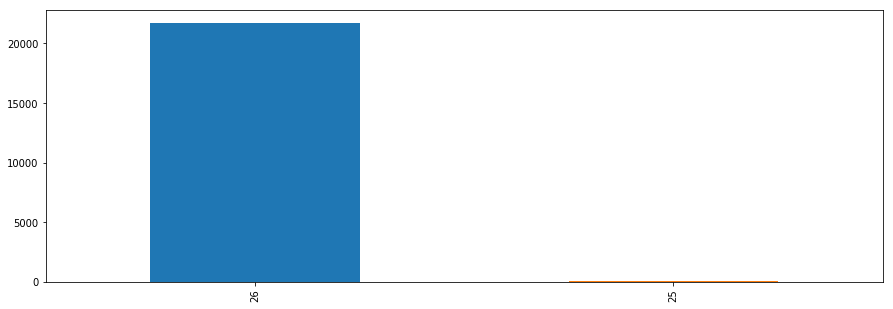

In [58]:
plots.frequency_of_attack("DAY")

#### Top n IP addresses in normal and malicious traffic

In [59]:
plots.top_n_IPs(5)

count
honeypot_flag id.orig_h             
0.0           128.143.136.134  26396
              199.111.226.137  16900
              128.143.67.11    16899
              113.96.223.207   12609
              128.143.69.101   11420
1.0           73.163.210.243    3806
              185.94.111.1      1859
              185.232.28.194    1715
              178.73.215.171    1114
              199.111.227.207    789

#### Top n ports in normal and malicious traffic

In [60]:
normal,malicious = plots.top_n_ports(10)
print(normal)
print(malicious)

                         row_id
honeypot_flag id.resp_p        
0.0           443        127281
              80          77587
              23          34117
              53          27392
              22          22822
              1433        17077
              8080        16261
              19          15710
              5060         7922
              10           6824
                         row_id
honeypot_flag id.resp_p        
1.0           19           3821
              520          1874
              23           1215
              5901         1164
              443           800
              8080          472
              30000         413
              5432          399
              80            368
              10            363


#### Top n pots - bar chart

<module 'matplotlib.pyplot' from 'C:\\Users\\arvra\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

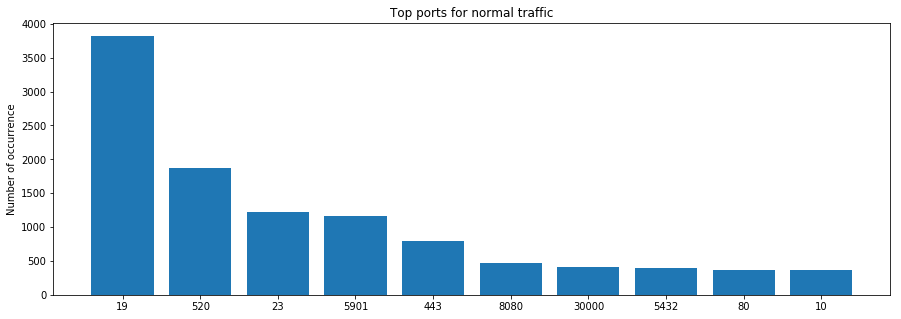

In [61]:
plots.top_n_port_plots(10,traffic_type = 1) #Normal traffic top 10 ports

<module 'matplotlib.pyplot' from 'C:\\Users\\arvra\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

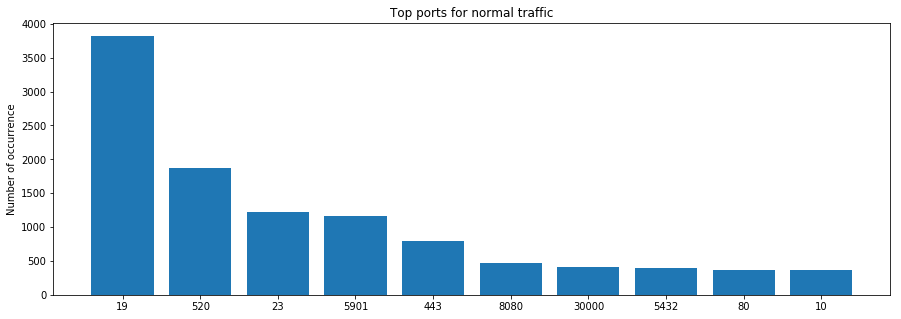

In [62]:
plots.top_n_port_plots(10,traffic_type = 1) #Malicious traffic top 10 ports

#### Prototype proportions

In [63]:
normal,malicous = plots.proto_proportions()
print(normal)
print(malicous)

tcp     79.258343
udp     17.846512
icmp     2.895145
Name: proto, dtype: float64
tcp     65.801660
udp     32.327725
icmp     1.870616
Name: proto, dtype: float64


#### Prototype distributions

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


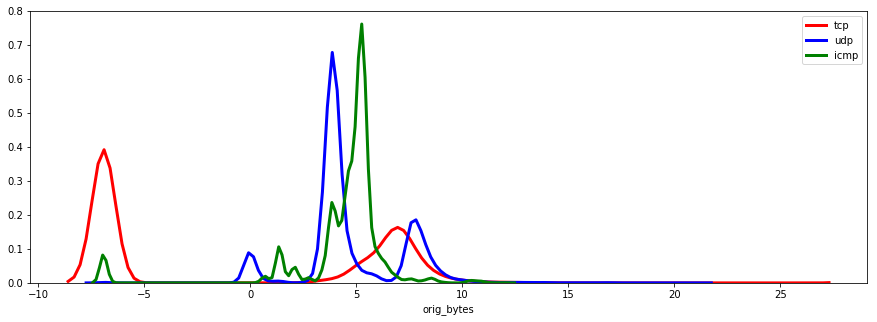

In [64]:
plots.proto_distribution(traffic_type = 0,scale = "log") #Normal traffic log scale

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arvra\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\arvra\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\a

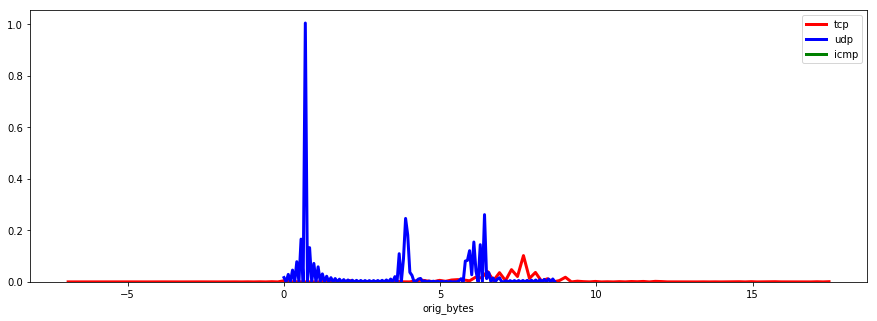

In [65]:
plots.proto_distribution(traffic_type = 1,scale = "log") #Malicious traffic log scale

#### Duration Distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C1847D54E0>,
      dtype=object)

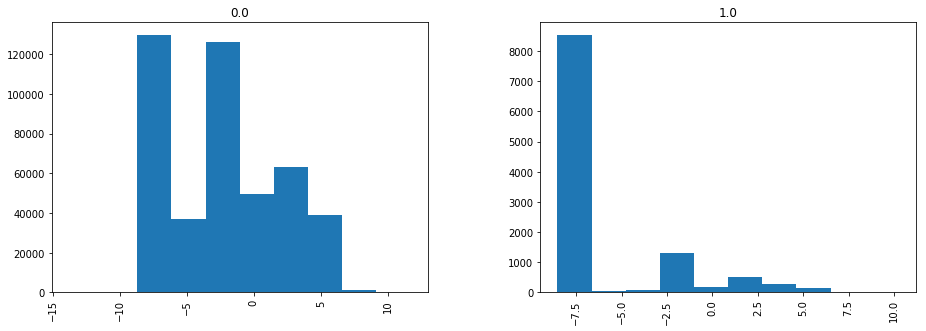

In [66]:
plots.duration_analysis(scale = "log") #Distribution analysis for Normal and Malicious traffic in log scale